# ATRP Kinetic Simulator Lite

## About this program

This is a lite version of ATRP and conventional radical polymerization kinetic simulator. You can select the type of polymerization you want to simulate. The types of polymerizations supported are conventional radical polymerization, normal ATRP, AGET ATRP, ARGET ATRP, eATRP, ATRP by continuous feeding of activators, and ICAR ATRP. You need to input the reaction time, the initial concentrations of reagents, and the rate coefficients of all reactions involved. The results include the concentration changes of all species with time, the monomer conversion vs. time, the first-order kinetic plot of monomer conversion vs. time, and the mole percent of end group loss vs. time. All reactions, rate coefficients, concentrations and monomer conversion information could be exported to a CSV file. This simulator does not distinguish polymers with different chain lengths. Thus, no molecular weight distribution information is provided. This is why the simulator is called a lite version.

For more information, please visit [https://wangyu16.github.io/macroarchilab/simulation/ATRP-kinetic-lite/](https://wangyu16.github.io/macroarchilab/simulation/ATRP-kinetic-lite/).

To run this program online, please visit [https://gke.mybinder.org/v2/gh/wangyu16/PolymerScienceEducation/master?filepath=ATRP_Kinetic_Simulator_Lite.ipynb](https://gke.mybinder.org/v2/gh/wangyu16/PolymerScienceEducation/master?filepath=ATRP_Kinetic_Simulator_Lite.ipynb). 

To download this program, please visit [https://github.com/wangyu16/PolymerScienceEducation](https://github.com/wangyu16/PolymerScienceEducation).

## Import packages 

In [230]:
from chempy import ReactionSystem, Substance
from chempy.kinetics.ode import get_odesys
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
import datetime
import csv

## Initialize reaction conditions

In [231]:
# Please choose the type of polymerization you want to simulate.
# Set the value of Poly_type as:
# 'conven' for conventional polymerization;
# 'normal' or any other value for normal ATRP;
# 'arget' for ARGET and AGET;
# 'eatrp' for electrochemical ATRP;
# 'cfa' for ATRP by continuous feeding of activators;
# 'icar' for ICAR ATRP.

Poly_type = 'icar'

In [232]:
#################    
# Reaction time #
#################    
# Set reaction time limit in seconds. 

react_time = 28800
   
#########################
# Monomer concentration #
#########################
# First set the initial concentration of monomer. Dead chains, D and DPn, should be 0 at the beginning. 

c0 = defaultdict(float, {'M': 5, 'D': 0, 'DPn': 0})

#########################################################################################################################
# In the following part, always remember to set proper rate coefficients for the reactions involved in your simulation. #
#########################################################################################################################

# Initiate the reaction system with null value. 

rsys = ReactionSystem.from_string("""
    """, substance_factory=Substance)

#########################
# Conventional and ICAR #
#########################
# If you are going to simulate conventional radical polymerization or ICAR ATRP, 
# the following set of reactions will be added. 
# Set the initial concentration of AIBN. AIBNR and AIBNRPn should be 0 at the beginning.

if Poly_type is 'conven' or Poly_type is 'icar':
    rsys = rsys + ReactionSystem.from_string("""
        AIBN -> AIBNR; 1e-5   
        AIBNR + M -> AIBNRPn; 1.3e3
        AIBNRPn + M -> AIBNRPn; 1.3e3    
        AIBNR + AIBNR -> D; 1e9
        AIBNRPn + AIBNR -> DPn; 1e9
        AIBNRPn + AIBNRPn -> DPn; 5e7
        """, substance_factory=Substance)
    c0.update({'AIBN': 0.005, 'AIBNR': 0, 'AIBNRPn':0})


#####################    
# All kinds of ATRP #
#####################
# If you are going to simulate any type of ATRP, the following set of reactions will be added. 
# Set the initial concentrations of RX, 
# CuI and CuII. Other concentrations should be 0.      
if Poly_type is not 'conven':
    rsys = rsys + ReactionSystem.from_string("""
        CuI + RX -> CuII + R; 1     
        CuII + R -> CuI + RX; 1e6
        CuI + RPnX -> CuII + RPn; 1
        CuII + RPn -> CuI + RPnX; 1e6     
        R + M -> RPn; 1.3e3
        RPn + M -> RPn; 1.3e3      
        R + R -> D; 1e9
        RPn + R -> DPn; 1e9
        RPn + RPn -> DPn; 5e7
        """, substance_factory=Substance)
    c0.update({'CuI': 0, 'RX': 0.05, 'CuII': 0.0005, 'R': 0, 'RPnX':0, 'RPn': 0})

##################   
# AGET and ARGET #
##################
# If you are going to simulate AGET or ARGET, the following set of reactions will be added. 
# set the initial concentration of the reducing agent. 
# ReducX should be 0.

if Poly_type is 'arget':
    rsys = rsys + ReactionSystem.from_string("""
        Reduc + CuII -> ReducX + CuI; 1e-1
        """, substance_factory=Substance)
    c0.update({'Reduc': 0.025, 'ReducX':0})
    
#########    
# eATRP #
#########
# If you are going to simulate eATRP, the following set of reactions will be added. 
# set the initial concentration of the electrons as a large number, e.g. > 200 times of RX, 
# which will remain nearly constant.
# Adjust the rate coefficient to change the polymerization rate. 

if Poly_type is 'eatrp':
    rsys = rsys + ReactionSystem.from_string("""
        elec + CuII -> CuI; 1e-4
        """, substance_factory=Substance)
    c0.update({'elec': 10})


######################
# Continuous feeding #
######################
# If you are going to simulate ATRP by continuous feeding of activators, the following set of reactions will be added. 
# Set the initial concentration of CuIsour as any large number, e.g. > 200 times of RX, which will remain nearly constant. 
# Adjust the rate coefficient to minic different feeding rate. 

if Poly_type is 'cfa':
    rsys = rsys + ReactionSystem.from_string("""
        CuIsour -> CuI; 1.4e-8
        """, substance_factory=Substance)
    c0.update({'CuIsour': 10})

########    
# ICAR #
########
# If you are going to simulate ICAR ATRP, the following set of reactions will be added. 
# Initialize the concentrations of AIBNRX and AIBNRPnX as 0. 

if Poly_type is 'icar':     
    rsys = rsys + ReactionSystem.from_string("""
        AIBNRPn + R -> DPn; 1e9
        AIBNRPn + RPn -> DPn; 5e7    
        AIBNR + R -> D; 1e9
        AIBNR + RPn -> DPn; 1e9
        CuI + AIBNRX -> CuII + AIBNR; 1
        AIBNR + CuII -> AIBNRX + CuI; 1e6
        AIBNRPnX + CuI -> CuII + AIBNRPn; 1
        AIBNRPn + CuII -> CuI + AIBNRPnX; 1e6
        """, substance_factory=Substance)  
    c0.update({'AIBNRX': 0, 'AIBNRPnX': 0})    

rsys

# After execute the the cell, double check the output rate coefficients. 

## Simulation and results

In [233]:
# Intigrate the differential equations. 

odesys, extra = get_odesys(rsys)
tout = sorted(np.concatenate((np.linspace(0, react_time), np.logspace(0, np.floor(np.log10(react_time))))))
result = odesys.integrate(tout, c0, atol=1e-12, rtol=1e-14)
kineticeq = list(zip(odesys.names, odesys.dep, odesys.exprs))
kineticeq

# Show the differential equations.

[('AIBN', y_0, -1.0e-5*y_0),
 ('AIBNR',
  y_1,
  1.0e-5*y_0 - 2000000000.0*y_1**2 - 1000000000.0*y_1*y_2 - 1300.0*y_1*y_5 - 1000000.0*y_1*y_7 - 1000000000.0*y_1*y_8 - 1000000000.0*y_1*y_9 + y_13*y_6),
 ('AIBNRPn',
  y_2,
  -1000000000.0*y_1*y_2 + 1300.0*y_1*y_5 + y_12*y_6 - 100000000.0*y_2**2 - 1000000.0*y_2*y_7 - 1000000000.0*y_2*y_8 - 50000000.0*y_2*y_9),
 ('D', y_3, 1000000000.0*y_1**2 + 1000000000.0*y_1*y_8 + 1000000000.0*y_8**2),
 ('DPn',
  y_4,
  1000000000.0*y_1*y_2 + 1000000000.0*y_1*y_9 + 50000000.0*y_2**2 + 1000000000.0*y_2*y_8 + 50000000.0*y_2*y_9 + 1000000000.0*y_8*y_9 + 50000000.0*y_9**2),
 ('M',
  y_5,
  -1300.0*y_1*y_5 - 1300.0*y_2*y_5 - 1300.0*y_5*y_8 - 1300.0*y_5*y_9),
 ('CuI',
  y_6,
  1000000.0*y_1*y_7 - y_10*y_6 - y_11*y_6 - y_12*y_6 - y_13*y_6 + 1000000.0*y_2*y_7 + 1000000.0*y_7*y_8 + 1000000.0*y_7*y_9),
 ('CuII',
  y_7,
  -1000000.0*y_1*y_7 + y_10*y_6 + y_11*y_6 + y_12*y_6 + y_13*y_6 - 1000000.0*y_2*y_7 - 1000000.0*y_7*y_8 - 1000000.0*y_7*y_9),
 ('R',
  y_8,
  -10

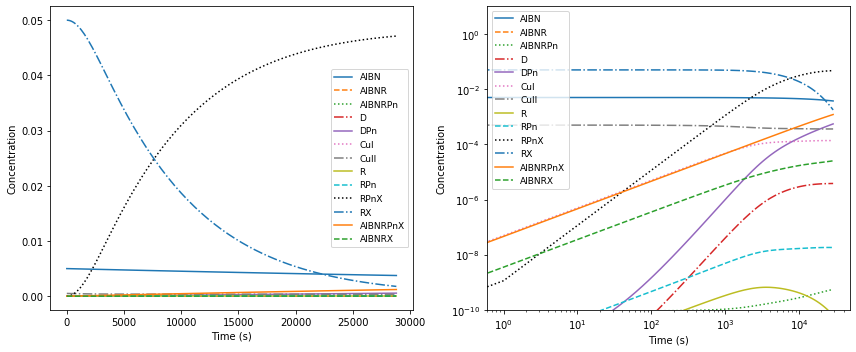

In [234]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax in axes:
     _ = result.plot(names=[k for k in rsys.substances if k != 'CuIsour'and k != 'M' and k!= 'elec'], ax=ax)
     _ = ax.legend(loc='best', prop={'size': 9})
     _ = ax.set_xlabel('Time (s)')
     _ = ax.set_ylabel('Concentration')
_ = axes[1].set_ylim([1e-10, 1e1])
_ = axes[1].set_xscale('log')
_ = axes[1].set_yscale('log')
_ = fig.tight_layout()

# Plot the concentrations of all species vs time 
# except those of monomer, CuI source in continuous feeding and electrons in eATRP. 

In [235]:
# Get monomer concentration and calculate conversion.

x=list(rsys.substances.keys()).index('M')
ConcM=list(result[1][:,x])
ConvM =list((ConcM[0]-ConcM)/ConcM[0])
LnM = list(np.log(ConcM[0]/ConcM))


# Get mole percent of end group loss, i.e., Tmol%.
if Poly_type is not 'conven':
    x=list(rsys.substances.keys()).index('RX')
    y=list(rsys.substances.keys()).index('RPnX')
    Tmol = list((result[1][0,x]-result[1][:,x]-result[1][:,y])/result[1][0,x])
else:
    Tmol = [0]*len(result[0])
result_cal = [list(result[0]),ConcM,ConvM,LnM,Tmol]

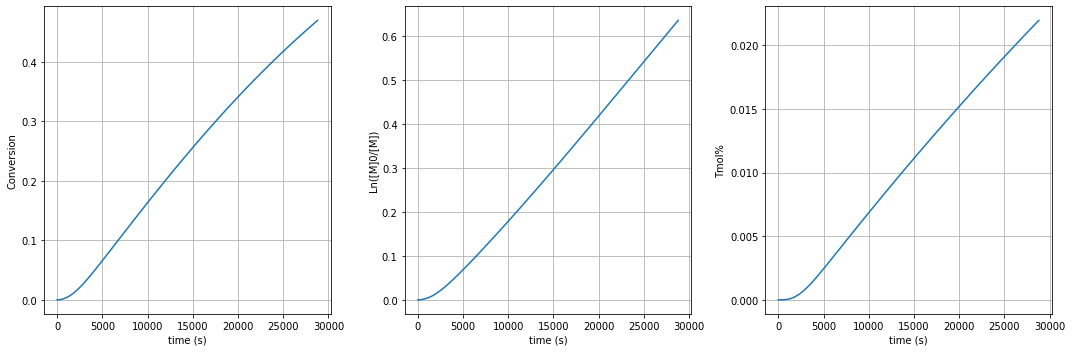

In [236]:
# Plot monomer conversion vs. time and first order kinetic plot. 

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
i=2
for ax in axes:
    _ = ax.plot(result_cal[0], result_cal[i])
    _ = ax.grid()
    i=i+1
_ = axes[0].set(xlabel='time (s)', ylabel='Conversion')
_ = axes[1].set(xlabel='time (s)', ylabel='Ln([M]0/[M])')
_ = axes[2].set(xlabel='time (s)', ylabel='Tmol%')
_ = fig.tight_layout()

## Additional reaction time

**If you are not simulating eATRP or ATRP by continuous feeding of activators, ignore the following several cells and jump to "Export the result" directly.**

In [237]:
# For ATRP with continuous feeding of activators and eATRP, after the feeding or the electric reduction stops,
# the polymerization may continue or may stop depends on the activity of the CuI complex.

############################    
# Additional reaction time #
############################    
# Set additional reaction time after the activator feeding or the electric reduction stops. 

react_time_add = 28800

# Get the final concentrations of all species in previous step, 
# which are the initial concentrations for the next step simulation.
c1 = result[1][-1].copy()

# Set the 'CuIsour' or 'e' concentration to 0. 
if Poly_type is 'cfa':
    x=list(rsys.substances.keys()).index('CuIsour')
elif Poly_type is 'eatrp':
    x=list(rsys.substances.keys()).index('elec')
else:
    print("You are not simulating ATRP by CFA or eATRP.")

if Poly_type is 'cfa' or Poly_type is 'eatrp':
    c1[x]=0 
    tout = sorted(np.concatenate((np.linspace(0, react_time_add), np.logspace(0, np.floor(np.log10(react_time_add))))))
    result2 = odesys.integrate(tout, c1, atol=1e-10, rtol=1e-12)

You are not simulating ATRP by CFA or eATRP.


In [238]:
if Poly_type is 'cfa' or Poly_type is 'eatrp':
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    for ax in axes:
         _ = result2.plot(names=[k for k in rsys.substances if k != 'CuIsour'and k != 'M' and k!= 'e'], ax=ax)
         _ = ax.legend(loc='best', prop={'size': 9})
         _ = ax.set_xlabel('Time (s)')
         _ = ax.set_ylabel('Concentration')
    _ = axes[1].set_ylim([1e-10, 1e1])
    _ = axes[1].set_xscale('log')
    _ = axes[1].set_yscale('log')
    _ = fig.tight_layout() # The plot shows the concentration changes during the additional reaction time. 

In [239]:
# Get monomer concentration and calculate conversion.
# Get mole percent of end group loss, i.e., Tmol%.

if Poly_type is 'cfa' or Poly_type is 'eatrp':
    x=list(rsys.substances.keys()).index('M')
    ConcM2=ConcM+list(result2[1][:,x])
    ConvM2 =list((ConcM2[0]-ConcM2)/ConcM2[0]) 
    LnM2 = list(np.log(ConcM2[0]/ConcM2))
    x=list(rsys.substances.keys()).index('RX')
    y=list(rsys.substances.keys()).index('RPnX')
    Tmol2 = Tmol+list((result[1][0,x]-result2[1][:,x]-result2[1][:,y])/result[1][0,x])
    result_cal2 = [list(result[0])+list(result[0][-1]+result2[0]),ConcM2,ConvM2,LnM2,Tmol2] 

In [240]:
# Plot monomer conversion vs. time and first order kinetic plot. 

if Poly_type is 'cfa' or Poly_type is 'eatrp':
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    i=2
    for ax in axes:
        _ = ax.plot(result_cal2[0], result_cal2[i])
        _ = ax.grid()
        i=i+1
    _ = axes[0].set(xlabel='time (s)', ylabel='Conversion')
    _ = axes[1].set(xlabel='time (s)', ylabel='Ln([M]0/[M])')
    _ = axes[2].set(xlabel='time (s)', ylabel='Tmol%')
    _ = fig.tight_layout() # Plot the conversion, Ln([M]0/[M]) and Tmol% in the whole time range. 

## Export the result 

In [203]:
# Export the result to a CSV file.
# The CSV file is saved in the same folder as this ipynb file. 

now = datetime.datetime.now()
filename = str(now.strftime("%Y-%m-%d_%Hh%Mm%Ss")) + '_ATRP_Simulation_Lite_' + str(Poly_type) + '.csv'

with open(filename, 'w', newline='') as f:
    thewriter = csv.writer(f)
    for rxn in rsys.rxns:
        thewriter.writerow([rxn])
    thewriter.writerow(['time']+[k for k in rsys.substances]+['conversion']+['ln([M]0/[M])']+['Tmol%'])
    i=0
    for concen in result[1]:
        thewriter.writerow([result_cal[0][i]]+[k for k in concen]+[ConvM[i]]+[LnM[i]]+[Tmol[i]])
        i+=1
    if Poly_type is 'cfa' or Poly_type is 'eatrp':
        for concen in result2[1][1:]:
            thewriter.writerow([result_cal2[0][i+1]]+[k for k in concen]+[ConvM2[i+1]]+[LnM2[i+1]]+[Tmol2[i+1]])
            i+=1